In [95]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import pmdarima as pm
import os
import re
import math

from datetime import datetime
from tbats import TBATS
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet

In [261]:
prices = pd.read_csv('PriceSeries.csv', parse_dates=['Date'], na_values=['', 'NA', 'NaN'])
prices = prices.set_index('Date')
prices.head()

,Gold,DXY,US 10y yield,CN 10y yield,DE 10y yield,SPX,US 2y yield,CN 2y yield,DE 2y yield
Date,,,,,,,,,
2022-01-03,1800.85,96.21,1.637,NaN,-0.124,4796.56,0.776,NaN,-0.596
2022-01-04,1814.56,96.26,1.649,2.793,-0.128,4793.54,0.760,2.350,-0.615
2022-01-05,1809.53,96.17,1.700,2.809,-0.124,4700.58,0.830,2.358,-0.620
2022-01-06,1788.68,96.32,1.728,2.822,-0.068,4696.05,0.874,2.380,-0.603
2022-01-07,1795.63,95.72,1.765,2.823,-0.029,4677.02,0.870,2.373,-0.578


## Gold Price Decomposition

Decomposition of gold price:

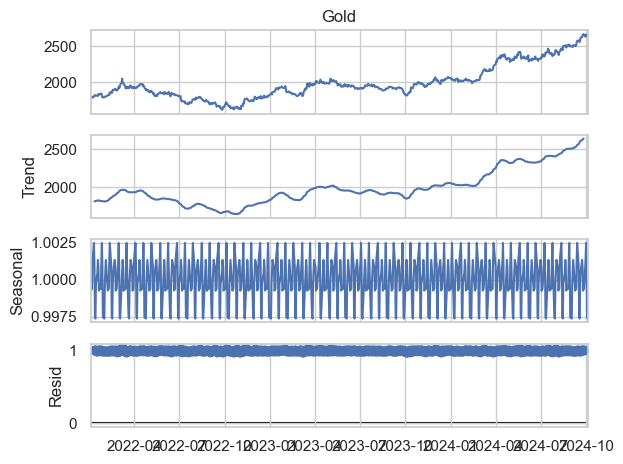

In [256]:
gold_prices = prices['Gold'].dropna()
gold_decomp = seasonal_decompose(gold_prices, model='multiplicative', period = 12)
gold_decomp.plot()
plt.show()

Tuning of P, D and Q:

In [257]:
print('ADF Statistic:', adfuller(gold_prices)[0])
print('p-value:', adfuller(gold_prices)[1])

ADF Statistic: 1.3328656898473166
p-value: 0.9967867603486904


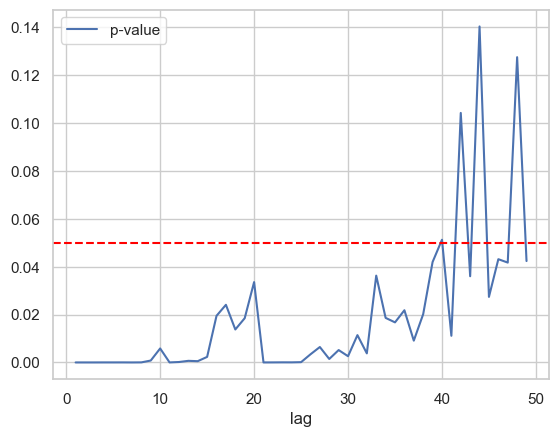

In [258]:
lag_p = pd.DataFrame({
    'lag': range(1, 50),
    'p-value': [adfuller(gold_prices.diff(lag).dropna())[1] for lag in range(1, 50)]
    })
lag_p.plot(x='lag', y='p-value')
plt.axhline(0.05, color='red', linestyle='--')

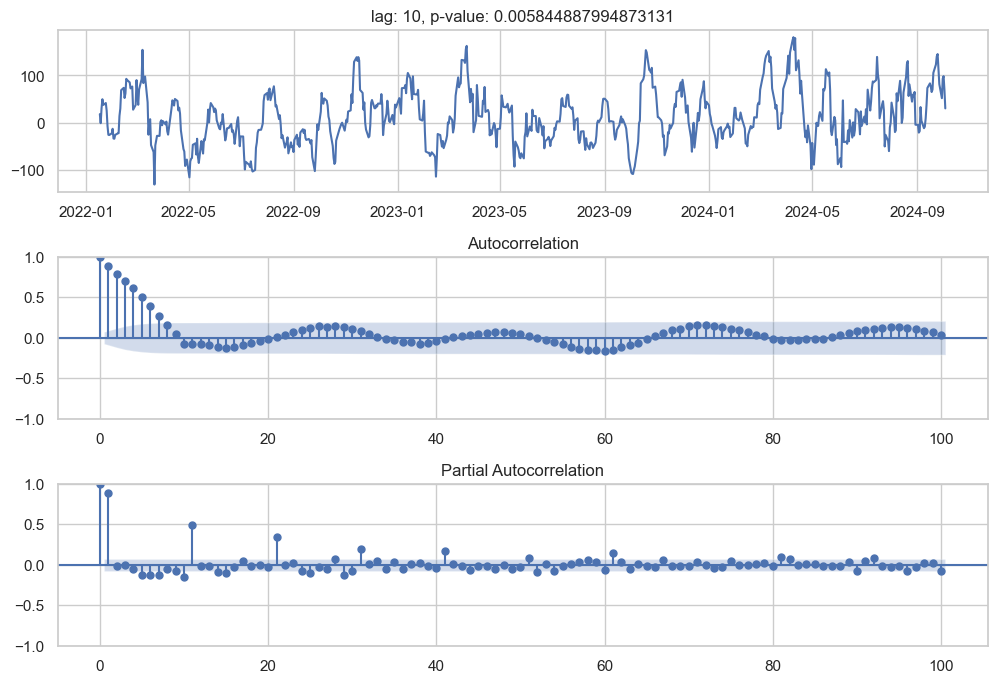

In [259]:
fig, ax = plt.subplots(3, 1, figsize=(12, 8))

lag = 10
gold_diff = gold_prices.diff(lag)
ax[0].plot(gold_diff.dropna())
ax[0].set_title(f'lag: {lag}, p-value: {adfuller(gold_diff.dropna())[1]}')

plot_acf(gold_diff.dropna(), lags=100, ax=ax[1])
plot_pacf(gold_diff.dropna(), lags=100, ax=ax[2])

plt.subplots_adjust(hspace=0.4)
plt.show()

In [260]:
modelSARIMA = pm.auto_arima(gold_prices, seasonal=True, m=7, d=1, D=10, max_order=None)
modelSARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  717
Model:             SARIMAX(0, 1, 0)x(0, 10, 0, 7)   Log Likelihood               -4577.677
Date:                            Fri, 11 Oct 2024   AIC                           9157.355
Time:                                    23:59:04   BIC                           9161.826
Sample:                                         0   HQIC                          9159.090
                                            - 717                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        26.9140      1.253     21.488      0.000      24.459      29.369
===================================================================================
Ljung-Box (L1) (Q):                   1.16   Jarque-Bera (JB):                24.41
Prob(Q):                              0.28   Prob(JB):                         0.00
Heteroskedasticity (H):               1.47   Skew:                            -0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Federal Funds Futures Matrix

In [335]:
# Define the matrix path
matrix_path = os.path.join("FFF_Matrix/")

# Get list of files with the pattern
matrix_list = [os.path.join(matrix_path, f) for f in os.listdir(matrix_path) if re.match(r'FedMeeting_\d{8}.csv', f)]

# Combine the data from all files
combined_data = pd.concat(
    [pd.read_csv(file, delimiter=',', on_bad_lines='skip').assign(Meeting=re.search(r'\d+', os.path.basename(file)).group()) for file in matrix_list]
)

# Convert 'Date' column to datetime format
combined_data['Date'] = pd.to_datetime(combined_data['Date'], format="%d/%m/%Y")

# Convert 'Meeting' column to datetime format
combined_data['Meeting'] = pd.to_datetime(combined_data['Meeting'], format="%Y%m%d")

# Calculate the difference in days
combined_data['DaysDiff'] = (combined_data['Meeting'] - combined_data['Date']).dt.days

# Add 'MeetingName' column with month and year
combined_data['MeetingName'] = combined_data['Meeting'].dt.strftime('%B %Y')

combined_data.fillna(0, inplace=True)

combined_data.tail()

,Date,(0-25),(25-50),(50-75),(75-100),(100-125),(125-150),(150-175),(175-200),(200-225),...,(1900-1925),(1925-1950),(1950-1975),(1975-2000),(2000-2025),(2025-2050),(2050-2075),(2075-2100),DaysDiff,MeetingName
198,2024-09-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,121,January 2025
199,2024-10-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,120,January 2025
200,2024-10-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,119,January 2025
201,2024-10-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,118,January 2025
202,2024-10-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117,January 2025


A complete FFF graph of incoming meetings:

In [336]:
# Define the target year and target ranges
year_start = 2024
target_ranges = ["(525-550)", "(500-525)", "(475-500)", "(450-475)", "(425-450)", "(400-425)",
                 "(375-400)", "(350-375)", "(325-350)", "(300-325)", "(275-300)", "(250-275)"]


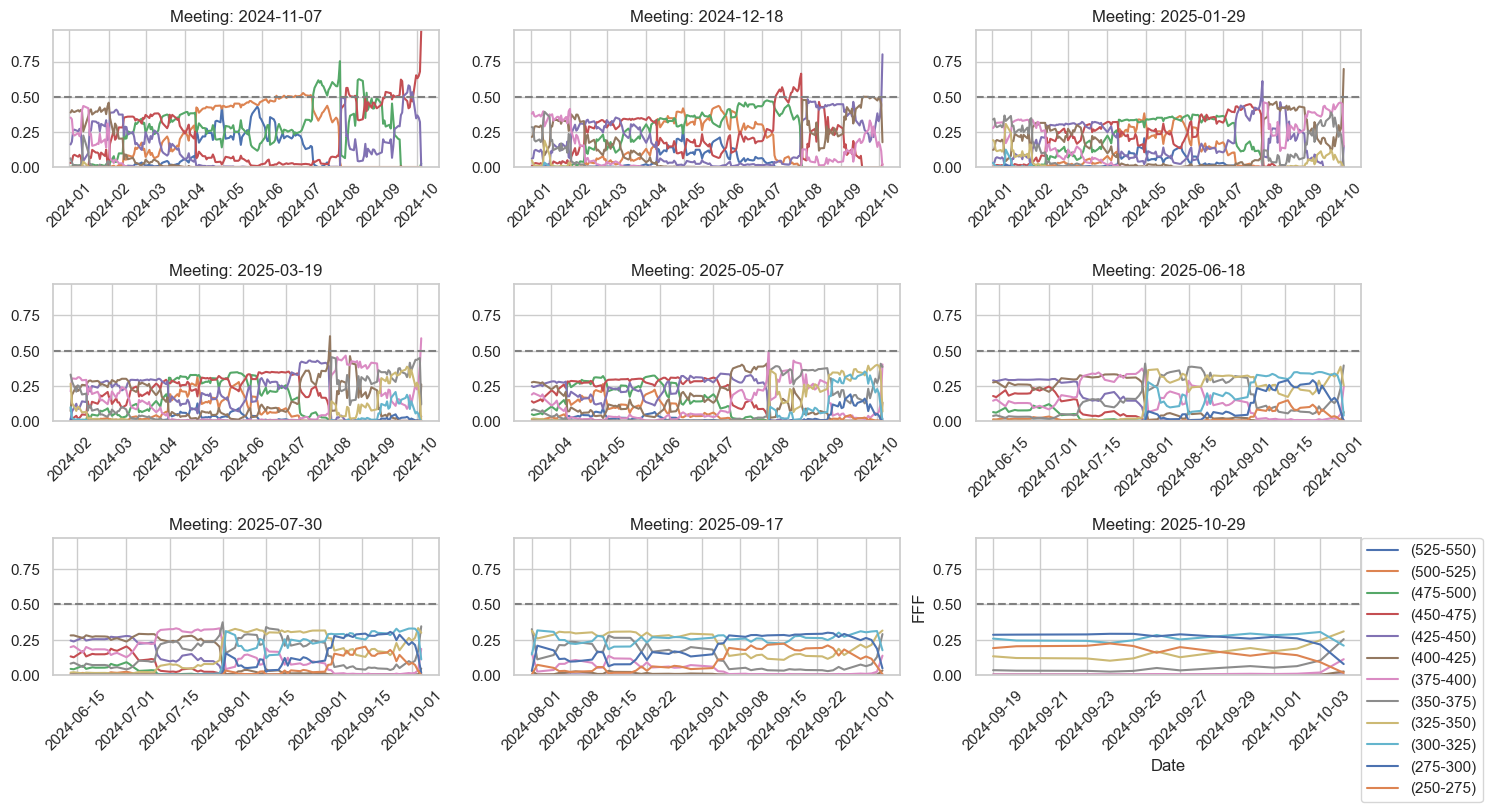

In [337]:
# Filter the data
fff = combined_data[combined_data['Date'].dt.year >= year_start]

# Further filter the data for future meetings
fff_latest = fff[fff['Meeting'] > pd.to_datetime(datetime.now())]
unique_meetings = fff_latest['Meeting'].unique()[fff_latest['Meeting'].unique().argsort()]

min_value = fff_latest[target_ranges].min().min()  # Global minimum
max_value = fff_latest[target_ranges].max().max()  # Global maximum

# Create the plot
sns.set_theme(style="whitegrid")

num_meetings = len(unique_meetings)
cols = 3  # You can change this number to adjust the layout
rows = math.ceil(num_meetings / cols)
fig, axes = plt.subplots(rows, cols, figsize=(15, 8))
axes = axes.flatten()

for i, meeting in enumerate(unique_meetings):
    ax = axes[i]  # Get the subplot axis
    fff_meeting = fff_latest[fff_latest['Meeting'] == meeting]
    
    # Plot all target range columns in the subplot
    for target_range in target_ranges:
        if target_range in fff_meeting.columns:
            ax.plot(fff_meeting['Date'], fff_meeting[target_range], label=target_range)
    
    ax.set_title(f'Meeting: {meeting.strftime("%Y-%m-%d")}')
    ax.set_ylim(min_value, max_value)
    ax.axhline(y=0.5, color='grey', linestyle='--')
    ax.tick_params(axis='x', rotation=45)  # Rotate x-axis labels to prevent overlap

# Remove any empty subplots
for i in range(num_meetings, len(axes)):
    fig.delaxes(axes[i])

# Automatically adjust layout
plt.xlabel('Date')
plt.ylabel('FFF')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=0.)
plt.tight_layout()
plt.show()

Functions of generating target range matrix and its single graph.

In [338]:
def sentiment_sym(n):
    """
    Generates the sentiment column name based on 'n' months.
    """
    return f'Sentiment_{n}mon'


In [339]:
def matrix_table(data, targetrange, n):
    """
    Generates a matrix for a target range, performing the specified calculations.
    
    Parameters:
    - data: DataFrame
    - targetrange: list of column names
    - n: integer (number of months)

    Returns:
    - combined_results: DataFrame with summarized results.
    """
    # Ensure targetrange is a list
    if isinstance(targetrange, str):
        targetrange = [targetrange]

    # List to store results for each target range
    results = []
    
    for tr in targetrange:
        # Select necessary columns
        fff_matrix = data[['Date', tr, 'Meeting', 'DaysDiff']].sort_values(by=['Date','Meeting'])

        # Filter where Meeting > Date
        fff_matrix = fff_matrix[fff_matrix['Meeting'] > fff_matrix['Date']]

        # Sort by Date and Meeting (earliest meetings first)
        fff_matrix = fff_matrix.sort_values(by=['Date', 'Meeting'])

        # Group by Date, and for each group, take the top 'n' nearest meetings
        fff_matrix = fff_matrix.groupby('Date').apply(lambda x: x.head(n), include_groups=True).reset_index(drop=True)

        # For each Date, calculate the weighted mean
        weighted_mean = fff_matrix.groupby('Date').apply(
            lambda group: pd.Series({
                f'Sentiment_{n}mon': (group[tr] * group['DaysDiff']).sum() / group['DaysDiff'].sum()
            })
        ).reset_index()

        # Add TargetRange column
        weighted_mean['TargetRange'] = tr

        # Append the result
        results.append(weighted_mean)

    # Combine results for all target ranges
    combined_results = pd.concat(results, ignore_index=True)
    
    return combined_results



In [340]:
def matrix_graph_single(data, n, ax):
    """
    Generates a line graph for sentiment for the specified number of months.
    
    Parameters:
    - data: DataFrame
    - n: integer (number of months)

    Returns:
    - A line plot displaying sentiment across different target ranges.
    """
    sentiment_column = sentiment_sym(n)
    
    # Plot the data
    sns.lineplot(x='Date', y=sentiment_column, hue='TargetRange', data=data, ax=ax)

    # Add a horizontal dashed line
    ax.axhline(y=0.5, linestyle='--', color='grey')

    # Set labels and title
    ax.set_title(f'{n}-month Sentiment for Various FFF Rates')
    ax.set_ylabel('Sentiment')
    ax.set_xlabel('Date')

    ax.get_legend().remove()
    ax.tick_params(axis='x', rotation=45)

/var/folders/tl/3k436bpn4w7328qlykmvjq3m0000gn/T/ipykernel_58773/2432088216.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  fff_matrix = fff_matrix.groupby('Date').apply(lambda x: x.head(n), include_groups=True).reset_index(drop=True)
/var/folders/tl/3k436bpn4w7328qlykmvjq3m0000gn/T/ipykernel_58773/2432088216.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_mean = fff_matrix.groupby('Date'

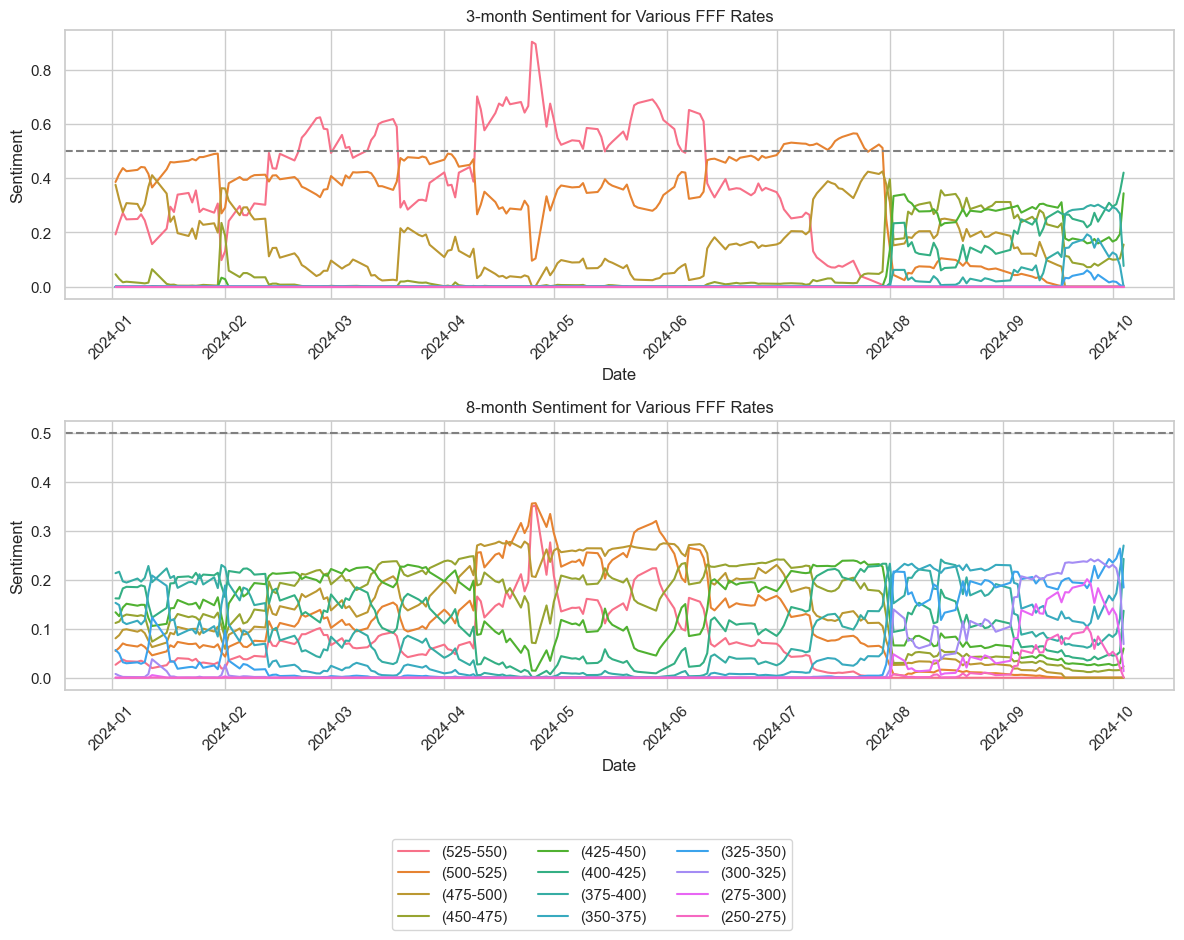

In [341]:
# Plot the 3-month and 8-month sentiment

matrix_3m = matrix_table(fff, target_ranges, 3)
matrix_8m = matrix_table(fff, target_ranges, 8)

fig, ax = plt.subplots(2, 1, figsize=(12, 8))

matrix_graph_single(matrix_3m, 3, ax[0])
matrix_graph_single(matrix_8m, 8, ax[1])

# Collect all handles and labels from both axes
handles, labels = [], []
for a in ax:
    for handle, label in zip(*a.get_legend_handles_labels()):
        if label not in labels:  # Avoid duplicate labels
            handles.append(handle)
            labels.append(label)

# Create a single legend outside the plots
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=3)

# Automatically adjust the layout to avoid overlap
plt.tight_layout()

# Show the combined plot
plt.show()

In [342]:
matrix_all = matrix_3m.join(matrix_8m.set_index(['Date', 'TargetRange']), on=['Date', 'TargetRange'], rsuffix='_8m')
matrix_all = matrix_all[['Date', 'TargetRange', 'Sentiment_3mon', 'Sentiment_8mon']].sort_values(by=['Date', 'TargetRange'])

## Dominating FFF rates

In [343]:
def mean_from_range(input_string):
    # Remove non-numeric characters except for the hyphen
    numeric_part = re.sub(r"[^0-9-]", "", input_string)
    # Split the string into numbers
    numbers = list(map(int, numeric_part.split("-")))
    # Return the mean divided by 100
    return np.mean(numbers) / 100

In [344]:
def calculate_dom_sentiments(df, target_mean):
    # Group by Date and compute the necessary statistics
    result = df.groupby('Date').apply(lambda group: pd.Series({
        'Sentiment_3mon_dom': np.nanmax(group['Sentiment_3mon']) * target_mean[np.nanargmax(group['Sentiment_3mon'])],
        'Sentiment_8mon_dom': np.nanmax(group['Sentiment_8mon']) * target_mean[np.nanargmax(group['Sentiment_8mon'])],
        'Dom_fff_3mon': target_mean[np.nanargmax(group['Sentiment_3mon'])],
        'Dom_fff_8mon': target_mean[np.nanargmax(group['Sentiment_8mon'])]
    }), include_groups=True).reset_index()
    
    return result

In [345]:
target_mean = list(map(mean_from_range, target_ranges))
target_mean = sorted(target_mean)

matrix_list_dom = calculate_dom_sentiments(matrix_all, target_mean)
matrix_list_dom.head()

/var/folders/tl/3k436bpn4w7328qlykmvjq3m0000gn/T/ipykernel_58773/2896355203.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = df.groupby('Date').apply(lambda group: pd.Series({


,Date,Sentiment_3mon_dom,Sentiment_8mon_dom,Dom_fff_3mon,Dom_fff_8mon
0,2024-01-02,1.976956,0.827039,5.125,3.875
1,2024-01-03,2.125945,0.838555,5.125,3.875
2,2024-01-04,2.238910,0.762439,5.125,3.875
3,2024-01-05,2.180442,0.752978,5.125,3.875
4,2024-01-08,2.205473,0.784502,5.125,3.875


Text(0.5, 0, 'Date')

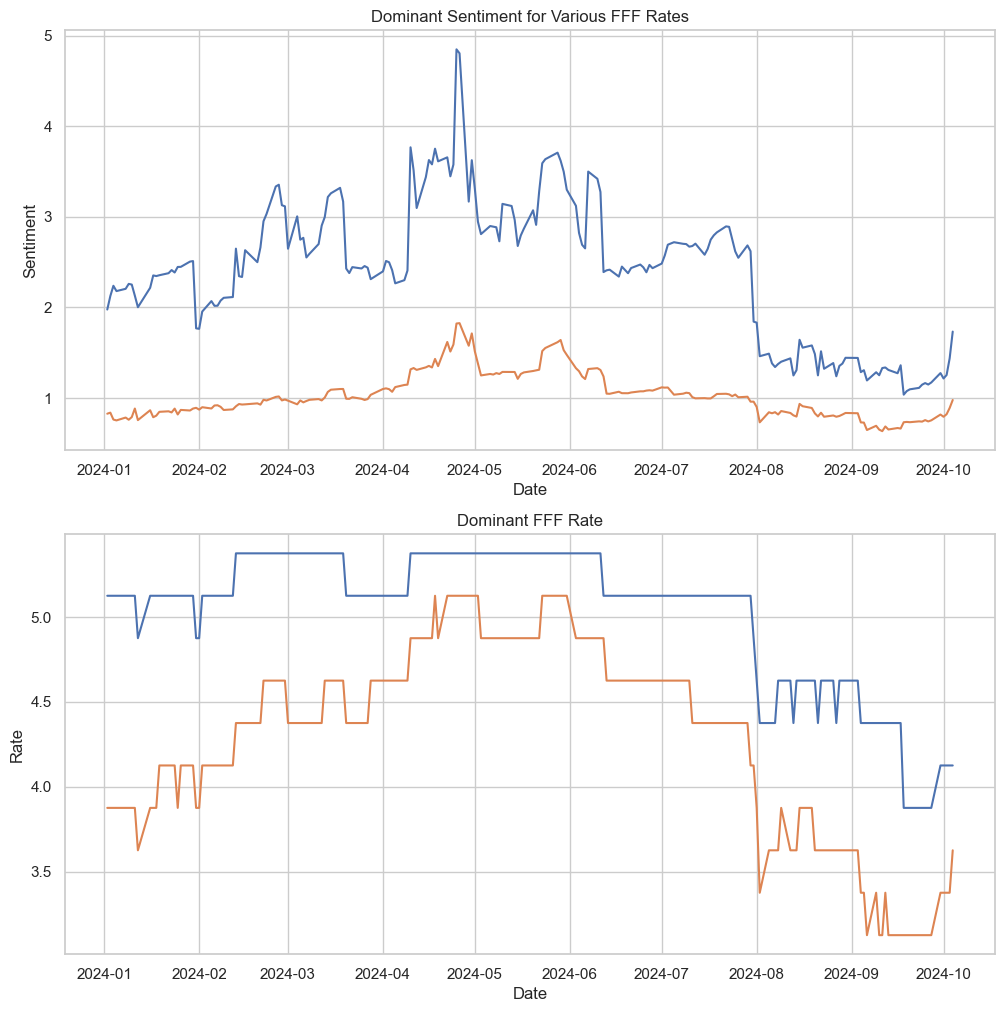

In [346]:
fig, ax = plt.subplots(2, 1, figsize=(12, 12))
ax[0].plot(matrix_list_dom['Date'], matrix_list_dom['Sentiment_3mon_dom'], label='3-month Sentiment')
ax[0].plot(matrix_list_dom['Date'], matrix_list_dom['Sentiment_8mon_dom'], label='8-month Sentiment')
ax[0].set_title('Dominant Sentiment for Various FFF Rates')
ax[0].set_ylabel('Sentiment')
ax[0].set_xlabel('Date')

ax[1].plot(matrix_list_dom['Date'], matrix_list_dom['Dom_fff_3mon'], label='3-month FFF Rate')
ax[1].plot(matrix_list_dom['Date'], matrix_list_dom['Dom_fff_8mon'], label='8-month FFF Rate')
ax[1].set_title('Dominant FFF Rate')
ax[1].set_ylabel('Rate')
ax[1].set_xlabel('Date')

## Relationship between Gold Price and FFF Matrix

In [360]:
aligned = matrix_list_dom.set_index('Date').join(prices[prices.index.year >= year_start], how='inner')
aligned.head()

,Sentiment_3mon_dom,Sentiment_8mon_dom,Dom_fff_3mon,Dom_fff_8mon,Gold,DXY,US 10y yield,CN 10y yield,DE 10y yield,SPX,US 2y yield,CN 2y yield,DE 2y yield
Date,,,,,,,,,,,,,
2024-01-02,1.976956,0.827039,5.125,3.875,2058.51,102.20,3.941,2.586,2.067,4742.83,4.324,2.276,2.454
2024-01-03,2.125945,0.838555,5.125,3.875,2040.19,102.49,3.920,2.580,2.017,4704.81,4.333,2.278,2.411
2024-01-04,2.238910,0.762439,5.125,3.875,2043.26,102.42,4.003,2.571,2.104,4688.68,4.387,2.283,2.517
2024-01-05,2.180442,0.752978,5.125,3.875,2045.50,102.41,4.051,2.567,2.143,4697.24,4.393,2.236,2.567
2024-01-08,2.205473,0.784502,5.125,3.875,2027.84,102.21,4.027,2.559,2.123,4763.54,4.375,2.253,2.545


<Figure size 1000x600 with 0 Axes>

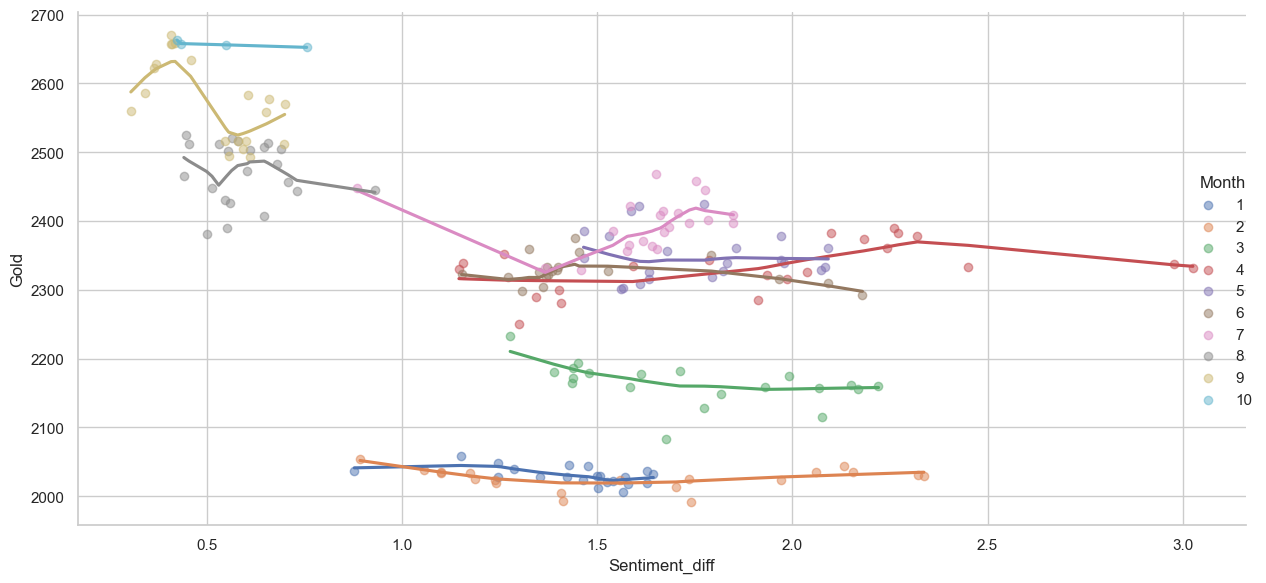

In [378]:
aligned['Sentiment_diff'] = aligned['Sentiment_3mon_dom'] - aligned['Sentiment_8mon_dom']
aligned['Month'] = aligned.index.month

plt.figure(figsize=(10, 6))

sns.lmplot(x='Sentiment_diff', 
           y='Gold', 
           data=aligned, 
           hue='Month', 
           lowess=True,    
           aspect=2,        
           height=6,       
           scatter_kws={'alpha':0.5}) 

plt.tight_layout()
plt.show()

In [377]:
aligned.columns

Index(['Sentiment_3mon_dom', 'Sentiment_8mon_dom', 'Dom_fff_3mon',
       'Dom_fff_8mon', 'Gold', 'DXY', 'US 10y yield', 'CN 10y yield',
       'DE 10y yield', 'SPX', 'US 2y yield', 'CN 2y yield', 'DE 2y yield',
       'Sentiment_diff', 'Month'],
      dtype='object')

<Figure size 1000x600 with 0 Axes>

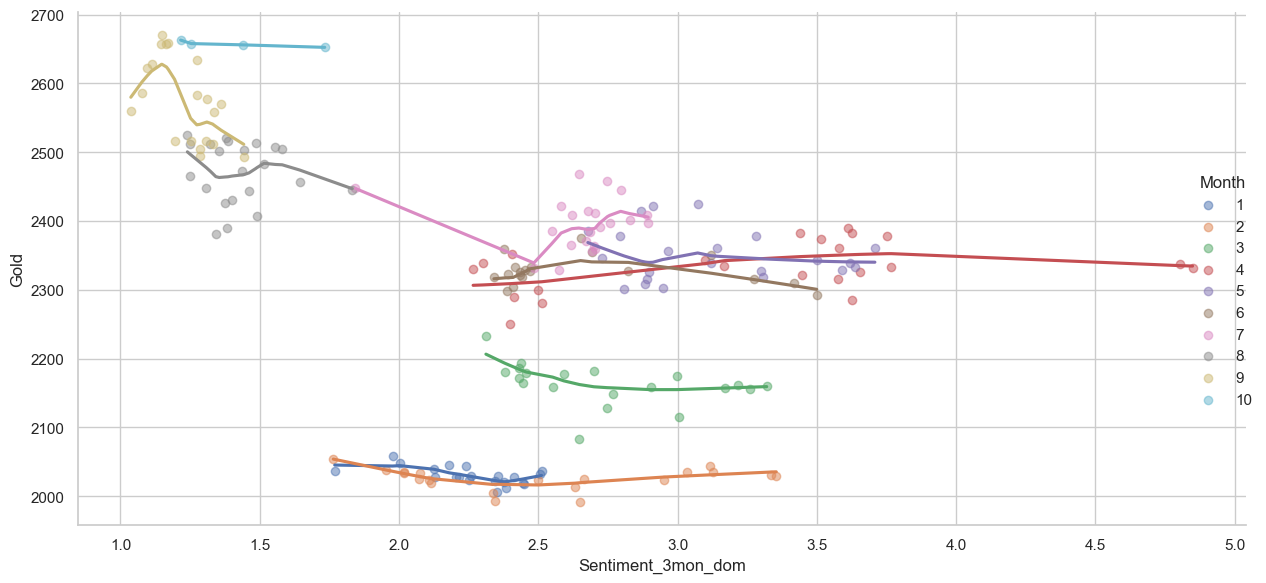

In [382]:
plt.figure(figsize=(10, 6))

sns.lmplot(x='Sentiment_3mon_dom', 
           y='Gold', 
           data=aligned, 
           hue='Month', 
           lowess=True,    
           aspect=2,        
           height=6,       
           scatter_kws={'alpha':0.5}) 

plt.tight_layout()
plt.show()